In [127]:
# Bibliotecas necessárias para o experimento

import numpy as np, numpy.random
import matplotlib.pyplot as plt
from random import randint
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from random import randint, uniform, random
from scipy.linalg import sqrtm

In [128]:
## CONSTANTES PARA O ALGORITMO GENÉTICO

ELITISMO = True
PORCENTAGEM_ELITISMO = 0.20

TAMANHO_POP = 50
TAXA_MUTACAO = 0.10
TAXA_CRUZAMENTO = 0.70
GERACOES = 100

# Valores mínimos e máximos para gerar uma população
MIN = 0
MAX = 200
 # 115, 150

In [129]:
def S(Ut, Uf, X):
    W = np.dot(np.transpose(Uf), Ut)
    T = np.transpose(W)
    A = np.dot(np.transpose(Ut), np.transpose(X))
    C = np.dot(A, Uf)
    L = W - np.identity(3) - 1/2*(W - np.identity(3))**2
    S = 2*np.trace(np.dot((-np.dot(T, C) + 2*C),L))
    #S = 2*np.trace(np.dot((-1/2*np.dot(C, T) - 1/2*np.dot(T, C) + 2*C),L))
    return S

In [130]:
def field(Ut, Uf, a, h, A, B):
    SA = S(Ut, Uf, A)
    SB = S(Ut, Uf, B)
    f = -a*SA-h*(SB/SA)
    return f

In [131]:
def lind(u, Ut, Uf, t, lbda):
    n = 1
    Ax = [[0, 0, 0],[0, 0, -1], [0, 1, 0]]
    Ay = [[0, 0, 1],[0, 0, 0], [-1, 0, 0]]
    Az = [[0, -1, 0],[1, 0, 0], [0, 0, 0]]
    B = [[(1-n*2)*lbda, 0, 0],[0, (1-n*2)*lbda, 0], [0, 0, (-n*2)*lbda]] # Amplitude Damping
    #B = [[-1.01*lbda, 0, 0],[0, -1.01*lbda, 0], [0, 0, -0.01*lbda]] # Phase Damping
    if t == 0:
        fx = u[0]
        fy = u[1]
        fz = u[2]
        F=np.dot(u[0],Ax)+np.dot(u[1],Ay)+np.dot(u[2],Az)+B
    else:
        fx=field(Ut, Uf, u[0], 0.35, Ax, B)
        fy=field(Ut, Uf, u[1], 0.31, Ay, B)
        fz=field(Ut, Uf, u[2], 0.34, Az, B)
        P=400

        if abs(fx) > P:
            if fx < 0:
                fx = -P
            else:
                fx = P
        if abs(fy) > P:
            if fy < 0:
                fy = -P
            else:
                fy = P
        if abs(fz) > P:
            if fz < 0:
                fz = -P
            else:
                fz = P

        F=np.dot(fx,Ax)+np.dot(fy,Ay)+np.dot(fz,Az)+B
        	
    return fx,fy,fz,F

In [132]:
def rungeKutta(u, Ut, Uf, h, t, lbda):

    if t == 0:
        
        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    else:

        fx,fy,fz,k1 = lind(u, Ut, Uf, t, lbda)
        k1 = np.dot(k1,Ut)
        fx,fy,fz,k2 = lind(u, (Ut+h/2*k1), Uf, t+h/2, lbda)
        k2 = np.dot(k2,(Ut+h/2*k1))
        fx,fy,fz,k3 = lind(u, (Ut+h/2*k2), Uf, t+h/2, lbda)
        k3 = np.dot(k3,(Ut+h/2*k2))
        fx,fy,fz,k4 = lind(u, (Ut+h*k3), Uf, t+h, lbda)
        k4 = np.dot(k4,(Ut+h*k3))
        a = fx;
        b = fy;
        c = fz;

    
    result = Ut+(h/6)*(k1+2*k2+2*k3+k4);
    return a,b,c,result

In [133]:
def func_objetivo(u, Ut, Uf, h, tempo, lbda):
    a, b, c, Ut1 = rungeKutta(u, Ut, Uf, h, tempo, lbda)
    return (np.linalg.norm(Ut1-Uf))**2

In [134]:
def gerar_populacao():
    populacao = np.zeros((TAMANHO_POP,3))
    for individuo in range(TAMANHO_POP):
        for genes in range(3):
            populacao[individuo,genes] = uniform(MIN, MAX)
    return populacao

In [135]:
def calcular_func(populacao, Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    valor_func = np.zeros(TAMANHO_POP)
    for individuo in range(TAMANHO_POP):
        valor_func[individuo] = func_objetivo(populacao[individuo,:], Ut, Uf, h, tempo, lbda)
    return valor_func

In [136]:
def selecao(valor_fitness):
    pos = np.random.choice(range(TAMANHO_POP), 2, replace=False)
    valor = valor_fitness[pos[0]] < valor_fitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [137]:
def divisao_fitness(valor_funcao_objetivo):
    divisao = 0
    for i in range(len(valor_funcao_objetivo)):
        divisao += valor_funcao_objetivo[i]
    return divisao

def fitness(valor_funca_objetivo):
    return valor_funca_objetivo/divisao_fitness(valor_funca_objetivo)

In [138]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [139]:
def mutacao(individuo, horizonte):
    
    # Gaussian function
    for i in range (0, horizonte):
        if random() < TAXA_MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(MIN, MAX)-2)**2))
    
    return individuo

In [140]:
def genetico(Ut, Uf, h, tempo, TAMANHO_POP, lbda):
    
    horizonte = 3
    pop = gerar_populacao()
    fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
    fit = fitness(fo)
    fit_edit = fit
    min_fit = min(fit)
            
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAMANHO_POP)/2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < TAXA_CRUZAMENTO:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)
                new_pop = np.vstack([new_pop, filho1, filho2])
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais])

        pop = new_pop
        fo = calcular_func(pop, Ut, Uf, h, tempo, TAMANHO_POP, lbda)
        fit = fitness(fo)
        min_fo = min(fo)
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)
                
    return pop[pos_min_fo,:][0,0]

In [141]:
def leis_controle(fx, fy, fz, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    plt.ylabel("Valores das leis de controle") 
    plt.xlabel('Tempo (u. a.)') 
    plt.plot(ts, fx, color='g', marker='o', linewidth=1, markersize=1, label="$f_x(t)$")
    plt.plot(ts, fy, color='b', marker='_', linewidth=1, markersize=1, label="$f_y(t)$")
    plt.plot(ts, fz, color='r', marker='.', linewidth=1, markersize=1, label="$f_z(t)$")
    plt.legend(loc="upper right")
    plt.title(fr"Leis de controle para $\gamma = {lbda}$")
    plt.show()

In [142]:
def fidelidade(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de fidelidade") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid[0]), color='g', marker='*', linewidth=1, markersize=1, label="Fidelidade de estados")
    ax.plot(ts, np.abs(fid[1]), color='r', marker='8', linewidth=1, markersize=1, label="Fidelidade da porta")
    ax.plot(ts, np.abs(fid[2]), color='b', marker='.', linewidth=1, markersize=1, label="Distância entre matrizes")
    ax.legend(loc="center right")
    ax.set_title(fr"Fidelidade com $\gamma = {lbda}$")

    # x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    # axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    # axins.set_xlim(0.009, 0.020)
    # axins.set_ylim(0.98, 1)

    # axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    # axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    # axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    # ax.indicate_inset_zoom(axins)
    
    plt.show()

In [143]:
def distance(fid, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel("Valores de distância") 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Distância entre os operadores de evolução com $\gamma = {lbda}$")

    #x1, x2, y1, y2 = 2.5, 4, 0, max(np.abs(fid))
    #axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    #axins.set_xlim(0.009, 0.020)
    #axins.set_ylim(0.98, 1)

    #axins.plot(ts, np.abs(fid), color='g', marker='*', linewidth=1, markersize=1, label=fr"$\gamma = {lbda}$")
    #ax.indicate_inset_zoom(axins)
    
    plt.show()

In [144]:
def densidade(rho, quant_pontos, lbda):
    ts = np.linspace(0, 0.1, quant_pontos)

    fig, ax = plt.subplots()

    ax.set_ylabel('Valores da matriz de densidade') 
    ax.set_xlabel('Tempo (u. a.)') 
    ax.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    ax.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    ax.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    ax.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")
    ax.legend(loc="center right")
    ax.set_title(fr"Evolução da matriz de densidade $\gamma = {lbda}$")

    x1, x2, y1, y2 = 2.5, 4, 0, max(max(abs(rho[0])), max(abs(rho[1])), max(abs(rho[2])), max(abs(rho[3])))
    axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)
    axins.set_xlim(0.009, 0.020)
    axins.set_ylim(0.98, 1)

    axins.plot(ts, abs(rho[0]), color='g', marker='o', linewidth=1, markersize=1, label=r"$\rho_{00}$")
    axins.plot(ts, abs(rho[1]), color='b', marker='8', linewidth=1, markersize=1, label=r"$\rho_{01}$")
    axins.plot(ts, abs(rho[2]), color='r', marker='.', linewidth=1, markersize=1, label=r"$\rho_{10}$")
    axins.plot(ts, abs(rho[3]), color='y', marker='*', linewidth=1, markersize=1, label=r"$\rho_{11}$")

    ax.indicate_inset_zoom(axins)
    
    plt.show()

In [145]:
def main():
    contador = 0
    r = 1
    w = 1
    aas = []
    u = [70, 106, 66, 0.35, 0.31, 0.34] # Hadamard
    
    Ut = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    Uf = [[0, 0, 1], [0, -1, 0], [1, 0, 0]] # Hadamard
    
    r0 = [[1], [0], [0]]
    rf = np.dot(Uf, r0)
    pf = [[1/2*(1+rf[2][0]), 1/2*(rf[0][0]-1j*rf[1][0])], [1/2*(rf[0][0]+1j*rf[1][0]), 1/2*(1-rf[2][0])]]
    
    h=0.001
    t=0
    i=0
    lbda=0.01
    # Proposta do algoritmo genético
    resultado_algoritmo_genetico = genetico(Ut, Uf, h, t, TAMANHO_POP, lbda) 
    u[0] = resultado_algoritmo_genetico[0]
    u[1] = resultado_algoritmo_genetico[1]
    u[2] = resultado_algoritmo_genetico[2]
    aas.append((u[0],u[1],u[2]))
    distance_vector = []
    fx_vector = []
    fy_vector = []
    fz_vector = []
    rho_vector = np.zeros((4,101),dtype=np.complex128)
    fid_vector = []
    fid_autores = []
       
    while t < 100:

        if contador == 0:
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            D = np.linalg.norm(Uto-Uf)**2
            distance_vector.append(D)
            fx_vector.append(a)
            fy_vector.append(b)
            fz_vector.append(c)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            rho_vector[0][w] = pt[0][0]
            rho_vector[1][w] = pt[0][1]
            rho_vector[2][w] = pt[1][0]
            rho_vector[3][w] = pt[1][1]
            fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            resultado_algoritmo_genetico = genetico(Uto, Uf, h, t, TAMANHO_POP, lbda) 
            u[0] = resultado_algoritmo_genetico[0]
            u[1] = resultado_algoritmo_genetico[1]
            u[2] = resultado_algoritmo_genetico[2]
            aas.append((u[0],u[1],u[2]))
            t += 1
            w += 1
        else:
            #h = 0.0001
            a,b,c,Uto = rungeKutta(u, Ut, Uf, h, t, lbda)
            D = np.linalg.norm(Uto-Uf)**2
            distance_vector.append(D)
            fx_vector.append(a)
            fy_vector.append(b)
            fz_vector.append(c)
            rt = np.dot(Uto, r0)
            pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
            rho_vector[0][w] = pt[0][0]
            rho_vector[1][w] = pt[0][1]
            rho_vector[2][w] = pt[1][0]
            rho_vector[3][w] = pt[1][1]
            fid_vector.append((np.trace(sqrtm(sqrtm(pt) @ pf @ sqrtm(pt))))**2)
            fid_autores.append((np.trace(np.dot(Uto, np.transpose(Uto)))+np.abs(np.trace(np.dot(np.transpose(Uf), Uto)))**2)/(3*(3+1)))
            t += 1
            w += 1
        if  (1/2*(1+rt[2][0]) > 1 or fid_autores[-1] > 1 or fid_vector[-1] > 1):
            contador = 2
            distance_vector[-1] = distance_vector[-2]
            rho_vector[0][w] = rho_vector[0][w-1]
            rho_vector[1][w] = rho_vector[1][w-1]
            rho_vector[2][w] = rho_vector[2][w-1]
            rho_vector[3][w] = rho_vector[3][w  -1]
            fid_vector[-1] = fid_vector[-2]
            fid_autores[-1] = fid_autores[-2]
        
            
        
        print(f"Distância: {distance_vector[-1]}")
        print(f"Fidelidade: {fid_vector[-1]}")
        print(f"Fidelidade da porta: {fid_autores[-1]}")
        Ut = Uto
        

    print(f"O rho gerado foi: {pt}") 
    print(f"A matriz de evolução Ut gerada foi: {Ut}")
    print(f"Portanto, a distância gerada foi: {D}")
    rt = np.dot(Ut, r0)
    pt = [[1/2*(1+rt[2][0]), 1/2*(rt[0][0]-1j*rt[1][0])], [1/2*(rt[0][0]+1j*rt[1][0]), 1/2*(1-rt[2][0])]]
    
    leis_controle(fx_vector,fy_vector,fz_vector,t,lbda)
    densidade(rho_vector,w,lbda)
    fidelidade([fid_vector, fid_autores, distance_vector],t,lbda)

    return fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, aas

In [146]:
import matplotlib.pyplot as plt

def histograma(componente, valores_as):

    valores = []
    # Extração dos valores para o componente escolhido
    valores_intermediarios = [sublista for sublista in a]
    for i in valores_intermediarios:
        valores.append(i[componente])
    
    # Criação do histograma
    plt.hist(valores, bins=10, edgecolor='black')
    plt.xlabel(f'Componente {["x", "y", "z"][componente]}')
    plt.ylabel('Frequência')
    plt.title(f'Histograma do Componente {["x", "y", "z"][componente]}')
    plt.show()


Começará a função principal


Distância: 7.890944388123841
Fidelidade: (0.5068206465330736+0.000147392494577998j)
Fidelidade da porta: 0.3244927552446792
Distância: 6.787507505191181
Fidelidade: (0.5767180075639763-3.651269757394069e-05j)
Fidelidade da porta: 0.2628677552581267
Distância: 4.817274735216147
Fidelidade: (0.6993496781442179-6.983776897758358e-05j)
Fidelidade da porta: 0.2788785529441595
Distância: 2.59317536022654
Fidelidade: (0.8379515796578475-1.5244421591066923e-15j)
Fidelidade da porta: 0.49113816922583203
Distância: 0.8123557122304295
Fidelidade: (0.9496275879183559+5.390011119466397e-05j)
Fidelidade da porta: 0.8094702337414175
Distância: 0.2456996262336865
Fidelidade: (0.9839836101890799-2.791639834331857e-15j)
Fidelidade da porta: 0.939916995739127
Distância: 0.08237634113256115
Fidelidade: (0.9953621319450546-8.514585990160756e-05j)
Fidelidade da porta: 0.9798371413111044
Distância: 0.02245334634945145
Fidelidade: (0.9986541625483576+7.711406541023145e-06j)
Fidelidade da porta: 0.994797749924

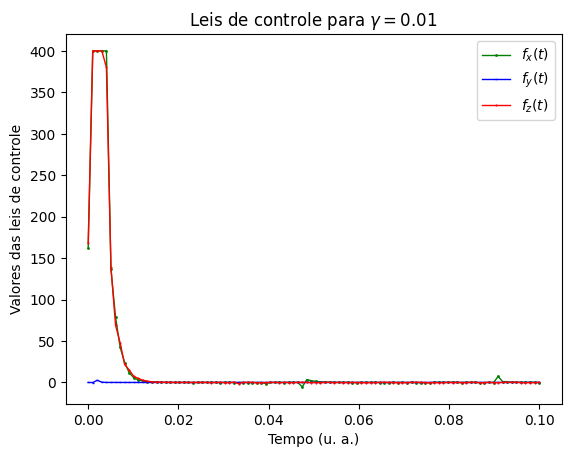

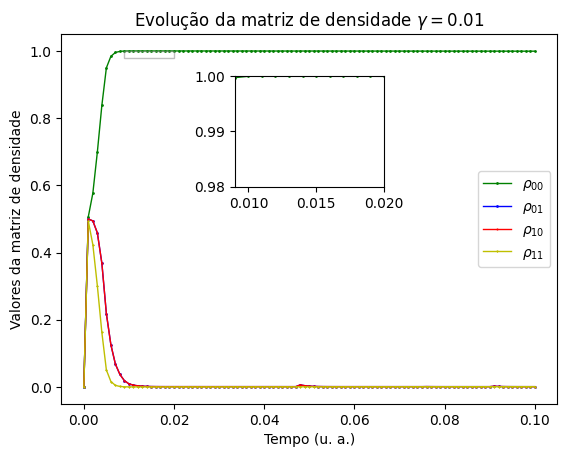

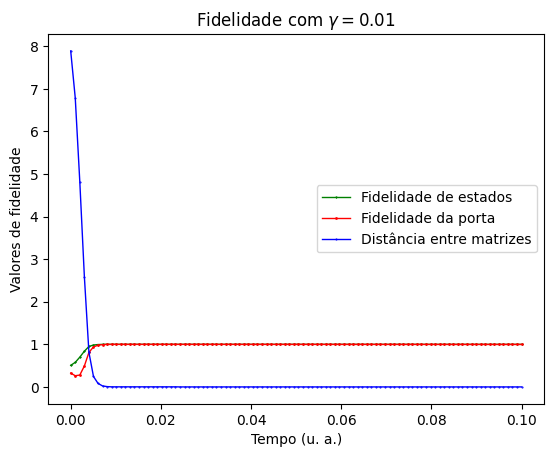

Terminou a função principal
Veja o log: (Dos estados)
[(0.5068206465330735822+0.00014739249457799799858j), (0.5767180075639763177-3.6512697573940684316e-05j), (0.69934967814421787206-6.983776897758357864e-05j), (0.83795157965784749615-1.5244421591066923499e-15j), (0.94962758791835584054+5.3900111194663969806e-05j), (0.98398361018907985797-2.791639834331856912e-15j), (0.995362131945054637-8.514585990160755604e-05j), (0.99865416254835753833+7.711406541023145158e-06j), (0.99968126036716125276+4.2965876156575870008e-07j), (0.9999223640306146239-1.8423931429102990247e-06j), (0.9999223640306146239-1.8423931429102990247e-06j), (0.9999223640306146239-1.8423931429102990247e-06j), (0.9999223640306146239-1.8423931429102990247e-06j), (0.9999223640306146239-1.8423931429102990247e-06j), (0.9999223640306146239-1.8423931429102990247e-06j), (0.9999223640306146239-1.8423931429102990247e-06j), (0.9999223640306146239-1.8423931429102990247e-06j), (0.9999223640306146239-1.8423931429102990247e-06j), (0.99992

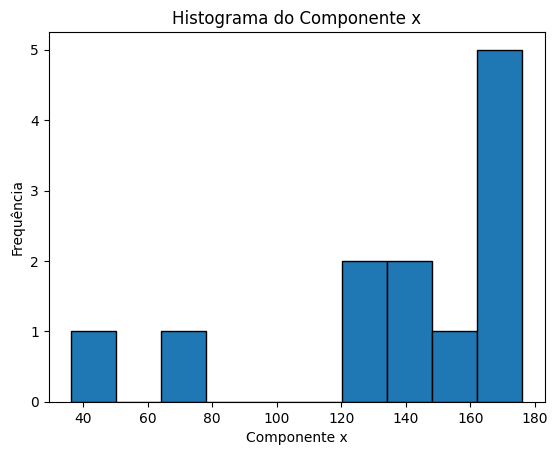

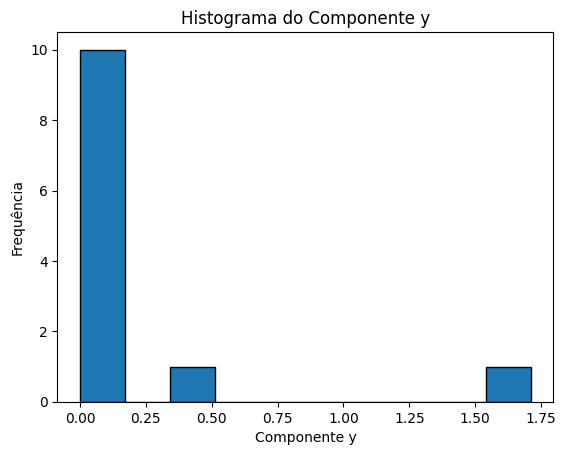

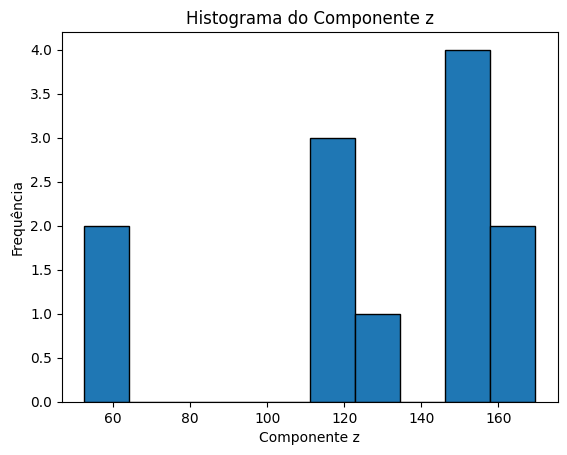

Terminou o histograma
Valores de média na iteração 1:
Portas: 0.9982395507742429
Estados: (0.9991954979211526-2.9732581841976652e-09j)
Distância: 7.016674966923563e-06
 


In [147]:
portas = []
estados = []
distancia = []
i = 1

print(f"Começará a função principal")
fid_vector, fid_autores, rho_vector, distance_vector, fx_vector, fy_vector, fz_vector, a = main()
print(f"Terminou a função principal")
print(f"Veja o log: (Dos estados)")
print(fid_vector)
print(f"Veja o log: (Das portas)")
print(fid_autores)

portas.append(fid_autores[-1])
estados.append(fid_vector[-1])
distancia.append(distance_vector[-1])

print(f"Começou o histograma")
histograma(0, a)
histograma(1, a)
histograma(2, a)
print(f"Terminou o histograma")

print(f"Valores de média na iteração {i}:")
print(f"Portas: {sum(portas)/i}")
print(f"Estados: {sum(estados)/i}")
print(f"Distância: {sum(distancia)/i}")
print(" ")

In [148]:
fid_vector

[(0.5068206465330735822+0.00014739249457799799858j),
 (0.5767180075639763177-3.6512697573940684316e-05j),
 (0.69934967814421787206-6.983776897758357864e-05j),
 (0.83795157965784749615-1.5244421591066923499e-15j),
 (0.94962758791835584054+5.3900111194663969806e-05j),
 (0.98398361018907985797-2.791639834331856912e-15j),
 (0.995362131945054637-8.514585990160755604e-05j),
 (0.99865416254835753833+7.711406541023145158e-06j),
 (0.99968126036716125276+4.2965876156575870008e-07j),
 (0.9999223640306146239-1.8423931429102990247e-06j),
 (0.9999223640306146239-1.8423931429102990247e-06j),
 (0.9999223640306146239-1.8423931429102990247e-06j),
 (0.9999223640306146239-1.8423931429102990247e-06j),
 (0.9999223640306146239-1.8423931429102990247e-06j),
 (0.9999223640306146239-1.8423931429102990247e-06j),
 (0.9999223640306146239-1.8423931429102990247e-06j),
 (0.9999223640306146239-1.8423931429102990247e-06j),
 (0.9999223640306146239-1.8423931429102990247e-06j),
 (0.9999223640306146239-1.8423931429102990247

In [149]:
fid_autores

[0.3244927552446792,
 0.2628677552581267,
 0.2788785529441595,
 0.49113816922583203,
 0.8094702337414175,
 0.939916995739127,
 0.9798371413111044,
 0.9947977499247083,
 0.9986004977380171,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9998988548262436,
 0.9999858967724724,
 0.9999592394146788,
 0.9999325809637504,
 0.999905927226147,
 0.9998792704003803,
 0.9998526168289464,
 0.9998259650931881,
 0.9997993207249379,
 0.999772669207934,
 0.9997460252888407,
 0.9997193885498028,
 0.9996927424239758,
 0.9996664956678618,
 0.9996399153756582,
 0.9996132782391479,
 0.9995866444933381,
 0.999560013381711,
 0.9995333763204978,
 0.9995067627945771,
 0.9994801333368359,
 0.9994534961429115,
 0.9994268746647591,
 0.9994002471098412,
 0.9995145212493

In [150]:
rho_vector

array([[ 0.00000000e+00+0.00000000e+00j,  5.06807449e-01+0.00000000e+00j,
         5.76485472e-01+0.00000000e+00j,  6.99003035e-01+0.00000000e+00j,
         8.37951933e-01+0.00000000e+00j,  9.49513856e-01+0.00000000e+00j,
         9.83922387e-01+0.00000000e+00j,  9.95356994e-01+0.00000000e+00j,
         9.98629190e-01+0.00000000e+00j,  9.99665053e-01+0.00000000e+00j,
         9.99916172e-01+0.00000000e+00j,  9.99964313e-01+0.00000000e+00j,
         9.99970891e-01+0.00000000e+00j,  9.99967076e-01+0.00000000e+00j,
         9.99959393e-01+0.00000000e+00j,  9.99950266e-01+0.00000000e+00j,
         9.99940598e-01+0.00000000e+00j,  9.99930727e-01+0.00000000e+00j,
         9.99920779e-01+0.00000000e+00j,  9.99910801e-01+0.00000000e+00j,
         9.99900811e-01+0.00000000e+00j,  9.99890817e-01+0.00000000e+00j,
         9.99880822e-01+0.00000000e+00j,  9.99870826e-01+0.00000000e+00j,
         9.99860834e-01+0.00000000e+00j,  9.99850846e-01+0.00000000e+00j,
         9.99840854e-01+0.00000000e+00

In [151]:
distance_vector

[7.890944388123841,
 6.787507505191181,
 4.817274735216147,
 2.59317536022654,
 0.8123557122304295,
 0.2456996262336865,
 0.08237634113256115,
 0.02245334634945145,
 0.0072047968184893755,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 0.001946361594189625,
 5.0310685838012145e-06,
 5.014646902727402e-06,
 5.012918183140103e-06,
 5.021699999962622e-06,
 5.025923690988898e-06,
 5.0353453062538716e-06,
 5.045836843148624e-06,
 5.059065191167077e-06,
 5.070724389668102e-06,
 5.157702546415725e-06,
 5.108019279064761e-06,
 5.101447214168274e-06,
 5.245859221609592e-06,
 5.200690926281004e-06,
 5.15757258045198e-06,
 5.2411661842268854e-06,
 5.20010348646914e-06,
 5.196351806095808e-06,
 5.259098883978683e-06,
 5.242809

In [152]:
fx_vector

[162.59097993881505,
 400,
 400,
 400,
 400,
 136.37403759166224,
 79.17787399648353,
 42.81501376147482,
 23.803807176226055,
 11.866707510431358,
 5.729091216292297,
 3.017844630959477,
 1.8384319118902972,
 1.1200541375592301,
 0.6824013678585724,
 0.41574436596337017,
 0.2532783291351372,
 0.15434316853128724,
 0.0942302983383825,
 0.058003869288330345,
 0.03680840156180658,
 0.025989792423235486,
 0.02975712023356805,
 -0.08485960796957714,
 0.06151464931509496,
 0.04220441035591567,
 0.04199844914723913,
 0.04831430741804667,
 0.04407545947956018,
 -0.0466130149031541,
 0.05074468756050993,
 0.05092019424515086,
 -0.0575845335521106,
 -0.059370051717170455,
 -0.06038338043138278,
 -0.05968040657769458,
 -0.09166092901602488,
 -0.08506830046594807,
 -0.06404147205847749,
 -1.3168216345302797,
 0.07511383180026604,
 0.0747842089547088,
 0.10666695375864242,
 -0.0711810307608399,
 0.13807826370772816,
 0.08183698994541846,
 0.08439110908180114,
 -5.368766799509085,
 3.49888331593218

In [153]:
fy_vector

[0.0,
 -0.07703150699994958,
 2.6576933715778157,
 0.3016316291894644,
 0.03220134671173254,
 0.03672317998641375,
 0.04578508419611343,
 0.007830172209080348,
 0.0028780515613506365,
 0.00027623874628762083,
 -0.00015737629945164458,
 -0.0003429320504655877,
 -0.0003610823904036438,
 -0.0003270735439375914,
 -0.00027568265194212937,
 -0.00021844880674926577,
 -0.0001592375569555294,
 -9.935383171020931e-05,
 -3.92396721928714e-05,
 2.0956525406497813e-05,
 8.118730589021987e-05,
 0.00014144026785194066,
 0.00020171532959910044,
 0.0002618047117257408,
 0.00032224092500097046,
 0.0003826020150300061,
 0.00044301390155767484,
 0.000503478235728545,
 0.0005640055381351853,
 0.0006245907963036035,
 0.0006852598021245844,
 0.0007460189241913574,
 0.0008068393868019752,
 0.0008677775241413622,
 0.0009287917578620347,
 0.000989940909584697,
 0.0010510479992161333,
 0.0011117345543621639,
 0.0011731685939873244,
 0.0012348530454269861,
 0.0012966708458399237,
 0.0013586465028175673,
 0.001420

In [154]:
fz_vector

[168.24396094671425,
 400,
 400,
 400,
 380.1862304693322,
 138.81689606139372,
 69.2747748511109,
 47.992538790155585,
 21.80708685404748,
 15.051649052111564,
 7.363980403018217,
 4.899777289046828,
 2.7186287608474213,
 1.5085098953065552,
 0.8370248429704849,
 0.4643879058789848,
 0.25759292196195527,
 0.14289026219458165,
 0.07946798899234171,
 0.04492133764443416,
 0.027420675655389838,
 0.023868826723413603,
 0.03861835207368192,
 -0.032352498804141934,
 0.03611304563213648,
 0.05095025917773881,
 0.0420272465245293,
 -0.04484765463943344,
 0.04882337213423288,
 0.050697377823966785,
 -0.0673587893247264,
 -0.14088094704696438,
 0.3319647181076825,
 -1.3022805175807761,
 0.07552239003655759,
 0.06526158497038254,
 0.08247316378559436,
 -0.3518526811604724,
 -0.06870552388287389,
 -0.118248280311711,
 0.07229568743363637,
 0.07330893720660446,
 -0.07491507883793187,
 0.07655991885811428,
 -0.07838085698306778,
 -0.07991864760095743,
 0.08110686968581304,
 0.06769690496906028,
 0.

In [155]:
a

[(162.59097993881505, 0.0, 168.24396094671425),
 (165.49511967194468, 0.0, 155.8476790004937),
 (36.31914462672732, 1.7111623155350446, 52.53616642742676),
 (67.6175398653115, 0.39468869779920024, 61.34742148747357),
 (169.83068393784075, 1.4137278498332215e-07, 153.29843740445767),
 (124.50207653211571, 0.0055682760207650195, 132.8422457381099),
 (147.28529029964156, 1.7860368254037892e-95, 113.03844975589573),
 (149.42777586782262, 0.00019437281341043913, 169.57851939859188),
 (173.75403140518065, 8.498000444860524e-06, 117.00466865801909),
 (176.05238557882555, 0.0, 157.11352183873396),
 (145.70533099956185, 0.0, 120.2949930919502),
 (123.77369931166555, 8.412770088468374e-05, 147.49917631059827)]